In [6]:
import cv2
import numpy as np
import os
from IPython.display import HTML, display
import base64

In [7]:
import firebase_admin
from firebase_admin import credentials, storage
from google.colab import userdata
import json
import os

key_json = userdata.get('firebase')

# Save the key to a temporary file
try:
    with open('firebase_key.json', 'w') as f:
        json.dump(json.loads(key_json), f)
    key_path = 'firebase_key.json'
except json.JSONDecodeError:
    # If the key is not valid JSON, assume it's already a file path
    key_path = key_json


cred = credentials.Certificate(key_path)

if not firebase_admin._apps:
    firebase_admin.initialize_app(cred, {
        'storageBucket': 'fairplayfairy-3e2eb.firebasestorage.app'
    })
    print("Firebase 앱이 성공적으로 초기화되었습니다.")
else:
    print("Firebase 앱이 이미 초기화되어 있습니다.")

# Storage 버킷 객체 가져오기 예시
bucket = storage.bucket()
print("Storage 버킷에 접근 성공:", bucket.name)

Firebase 앱이 이미 초기화되어 있습니다.
Storage 버킷에 접근 성공: fairplayfairy-3e2eb.firebasestorage.app


In [8]:
def track_aim_in_video(input_path, output_path="result_local.mp4"):
    """
    영상 파일을 입력받아 옵티컬 플로우로 에임을 추적하고,
    결과 영상 저장 및 에임 이동 데이터를 반환합니다.
    output_path가 None이면 결과 영상을 저장하지 않습니다.
    """
    aim_movements = []
    try:
        cap = cv2.VideoCapture(input_path)
        if not cap.isOpened():
            print(f"Error: 영상을 열 수 없습니다: {input_path}") # Added input_path for better error message
            return None

        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # Corrected typo here
        fps = int(cap.get(cv2.CAP_PROP_FPS))

        out = None
        if output_path is not None:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        ret, prev_frame = cap.read()
        if not ret:
            print(f"Error: 첫 프레임을 읽을 수 없습니다: {input_path}") # Added input_path for better error message
            cap.release()
            if out is not None:
                out.release()
            return None

        roi_x, roi_y = int(width * 0.2), int(height * 0.2)
        roi_w, roi_h = int(width * 0.6), int(height * 0.6)

        prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
        prev_roi = prev_gray[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]

        frame_count = 0
        # Removed total_frames as it was causing issues with some webm files
        # total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


        while True:
            ret, frame = cap.read()
            if not ret:
                break

            frame_count += 1
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            roi = gray[roi_y:roi_y+roi_h, roi_x:roi_x+roi_w]

            flow = cv2.calcOpticalFlowFarneback(prev_roi, roi, None, 0.5, 3, 15, 3, 5, 1.2, 0)

            dx, dy = np.mean(flow[..., 0]), np.mean(flow[..., 1])

            aim_dx, aim_dy = -dx, -dy
            aim_movements.append((aim_dx, aim_dy)) # 에임 이동 데이터 저장

            aim_speed = np.sqrt(aim_dx**2 + aim_dy**2)

            if aim_speed > 1.0:
                center_x, center_y = width // 2, height // 2
                arrow_end_x = int(center_x + aim_dx * 20)
                arrow_end_y = int(center_y + aim_dy * 20)

                cv2.arrowedLine(frame, (center_x, center_y), (arrow_end_x, arrow_end_y),
                                (0, 255, 255), 3, tipLength=0.3)

            if out is not None:
                out.write(frame)
            prev_roi = roi

            # Removed per-frame progress print
            # if frame_count % 30 == 0:
            #     print(f"진행률: {frame_count} / {total_frames} 프레임 처리 중...")


        if output_path is not None:
            print(f"✅ 영상 처리가 완료되었습니다. 결과가 '{output_path}'에 저장되었습니다.")
        # Removed the else print as it will be handled by the calling loop
        # else:
        #     print(f"✅ 영상 처리가 완료되었습니다. (결과 영상 저장 안함)")


        cap.release()
        if out is not None:
            out.release()
        return aim_movements

    except Exception as e:
        print(f"오류가 발생했습니다: {e}")
        return None

# --- 실행 ---
aim_data = None
if 'input_filename' in locals() and os.path.exists(input_filename):
    output_filename = "result_local.mp4"
    aim_data = track_aim_in_video(input_filename, output_filename)
else:
    print("⚠️ 파일 경로를 먼저 확인해주세요.")

⚠️ 파일 경로를 먼저 확인해주세요.


In [9]:
import random
import tempfile
import matplotlib.pyplot as plt

videos = list(bucket.list_blobs(prefix='videos/'))
webm_files = [video for video in videos if video.name.endswith('.webm')]

sample_size = 1 # Remove sample_size
random_videos = random.sample(webm_files, sample_size) # random sampling

all_aim_data = []

# webm_files 이면 모든 webm 파일 optical flow 추출(영상저장 X, 시각화 X)
for i, video_blob in enumerate(random_videos): # Iterate over all webm files
    print(f"[{i+1}/{len(random_videos)}] 처리 중: {video_blob.name}", end=" ") # Modified print for inline progress
    fd, temp_path = tempfile.mkstemp(suffix=".webm")

    try:
        # Download the video blob to the temporary file
        video_blob.download_to_filename(temp_path)

        aim_data = track_aim_in_video(temp_path, output_path=None)
        if aim_data is not None:
            all_aim_data.append({'name': video_blob.name, 'data': aim_data}) # Store video name with data
            print("✅ 완료") # Print completion message
        else:
            print("❌ 실패") # Print failure message

    except KeyboardInterrupt:
        print("\nKeyboard interrupt detected. Stopping processing.")
        break # Exit the loop if interrupted
    except Exception as e:
        print(f"오류 발생: {e}") # Print other exceptions

    finally:
        os.close(fd)
        os.remove(temp_path)

print(f"\n{len(all_aim_data)}개의 데이터 수집 완료.")

[1/1] 처리 중: videos/5a8247c9-193e-4737-8c7f-bcf9e06355ac.webm ✅ 완료

1개의 데이터 수집 완료.


/tmp/ipython-input-336845611.py:36: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([per_video_stats['vel_mean'],


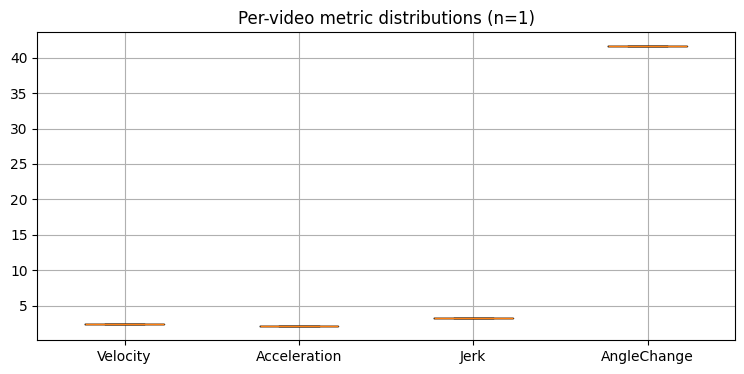

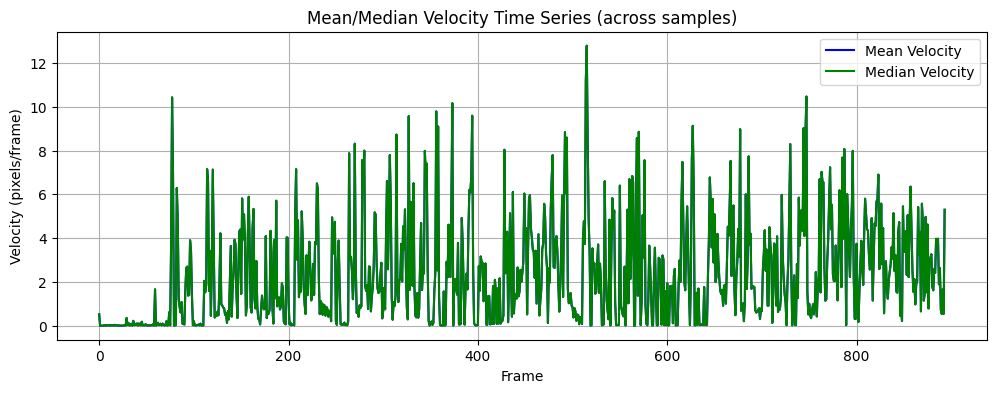

vel_mean: mean=2.339, std=0.000
acc_mean: mean=2.072, std=0.000
jerk_mean: mean=3.283, std=0.000
anglechg_mean: mean=41.617, std=0.000


In [10]:
if not all_aim_data:
    print("분석 데이터 없음.")
else:
    # per-video metric(평균)과 velocity 시퀀스 수집
    vel_seqs = []
    per_video_stats = {'vel_mean': [], 'acc_mean': [], 'jerk_mean': [], 'anglechg_mean': []}

    for item in all_aim_data:
        moves = np.array(item['data'])  # Convert list of tuples to NumPy array
        vel = np.linalg.norm(moves, axis=1)
        acc = np.linalg.norm(np.diff(moves, axis=0), axis=1) if len(moves) > 1 else np.array([0.0])
        jerk = np.linalg.norm(np.diff(moves, n=2, axis=0), axis=1) if len(moves) > 2 else np.array([0.0])
        ang = np.arctan2(moves[:,1], moves[:,0]) * 180/np.pi
        angchg = np.abs(((np.diff(ang) + 180) % 360) - 180) if len(ang) > 1 else np.array([0.0])

        per_video_stats['vel_mean'].append(np.mean(vel))
        per_video_stats['acc_mean'].append(np.mean(acc))
        per_video_stats['jerk_mean'].append(np.mean(jerk))
        per_video_stats['anglechg_mean'].append(np.mean(angchg))

        vel_seqs.append(vel)

    # 시간 길이 맞추기 (짧은 시퀀스는 마지막 값으로 패딩)
    max_len = max(len(s) for s in vel_seqs)
    padded = np.zeros((len(vel_seqs), max_len))
    for idx, seq in enumerate(vel_seqs):
        padded[idx, :len(seq)] = seq
        if len(seq) < max_len:
            padded[idx, len(seq):] = seq[-1]

    mean_ts = np.mean(padded, axis=0)
    median_ts = np.median(padded, axis=0)

    # 1) per-video metric boxplot
    plt.figure(figsize=(9,4))
    plt.boxplot([per_video_stats['vel_mean'],
                 per_video_stats['acc_mean'],
                 per_video_stats['jerk_mean'],
                 per_video_stats['anglechg_mean']],
                labels=['Velocity','Acceleration','Jerk','AngleChange'])
    plt.title(f'Per-video metric distributions (n={len(per_video_stats["vel_mean"])})')
    plt.grid(True)
    plt.show()

    # 2) 평균 시간축 시계열
    plt.figure(figsize=(12,4))
    plt.plot(mean_ts, label='Mean Velocity', color='b')
    plt.plot(median_ts, label='Median Velocity', color='g')
    plt.xlabel('Frame')
    plt.ylabel('Velocity (pixels/frame)')
    plt.title('Mean/Median Velocity Time Series (across samples)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 3) 요약 통계 출력
    for k, vals in per_video_stats.items():
        print(f"{k}: mean={np.mean(vals):.3f}, std={np.std(vals):.3f}")